# Echocardiogram Data Set from UCI

## Data for classifying if patients will survive for at least one year after a heart attack



This analysis performs survival analysis to predict survival month ("survival") base on the covariates in Echocardiogram - UCI data. The survival analysis includes use of censoring data, Kaplan-Meier estimates, Log-rank test, and Cox proportional hazards model. There is little correlation between survival time and the covariates, which makes it hard to derive significant results. However, by exploring Kaplan-Meier estimates, it seems to have difference in survival time in the first two years after heart attacks.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.impute import SimpleImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

In [16]:
# Load the data
data = pd.read_csv("echocardiogram.csv")
data.head()

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score,wallmotion-index,mult,name,group,aliveat1
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,14.0,1.00,1.000,name,1,0.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,14.0,1.70,0.588,name,1,0.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,14.0,1.00,1.000,name,1,0.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,16.0,1.45,0.788,name,1,0.0
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,18.0,2.25,0.571,name,1,0.0


In [17]:
data.shape

(133, 13)

we have 133 observations and 13 variables

In [18]:
# checking for missing values
data.isnull().sum().sort_values(ascending=False)

aliveat1                58
group                   23
epss                    16
lvdd                    12
fractionalshortening     9
age                      7
wallmotion-score         5
mult                     4
survival                 3
wallmotion-index         3
alive                    2
name                     2
pericardialeffusion      1
dtype: int64

There are many missing values across variables. One of the option to deal with the missing values will be to drop them, but since we only have 133 variables, imputing them will be a better solution

In [19]:
print('\nMissing data percentage (%):')
print((data.isnull().sum()/data.count()*100).sort_values(ascending=False))


Missing data percentage (%):
aliveat1                77.333333
group                   20.909091
epss                    13.675214
lvdd                     9.917355
fractionalshortening     7.258065
age                      5.555556
wallmotion-score         3.906250
mult                     3.100775
survival                 2.307692
wallmotion-index         2.307692
alive                    1.526718
name                     1.526718
pericardialeffusion      0.757576
dtype: float64


<AxesSubplot:>

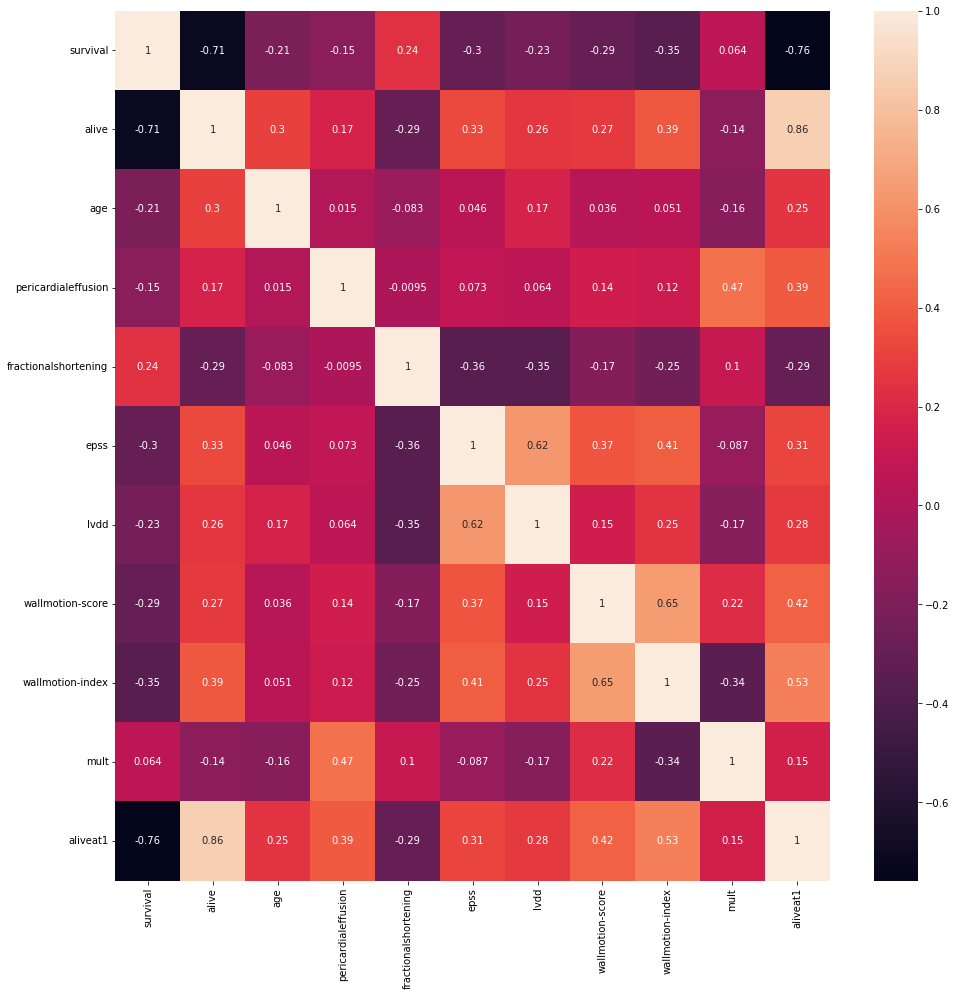

In [20]:
# correlation matrix
correlation=data.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(correlation,annot=True)

In [21]:
# Imputing missing data
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
COLUMNS = ['age', 'pericardialeffusion', 'fractionalshortening', 'epss', 'lvdd', 'wallmotion-score']
X = imp_mean.fit_transform(data[COLUMNS])
data_X = pd.DataFrame(X,
                    columns = COLUMNS)
data_X.shape

(133, 6)

<AxesSubplot:>

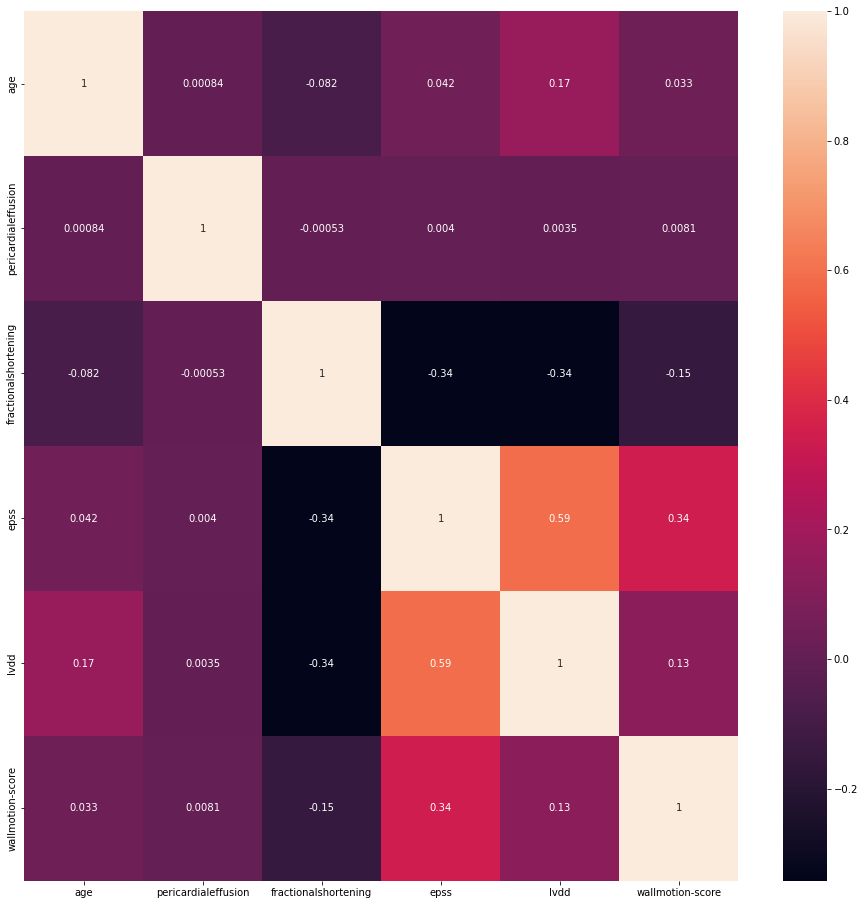

In [22]:
correlation=data_X.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(correlation,annot=True)

In [24]:
col_keep = ['survival', 'alive']
df_keep = data[col_keep]
df_keep.shape

(133, 2)

In [25]:
df = pd.concat([df_keep, data_X], axis = 1)
df = df.dropna() 
print(df.isnull().sum())
print(df.shape)

survival                0
alive                   0
age                     0
pericardialeffusion     0
fractionalshortening    0
epss                    0
lvdd                    0
wallmotion-score        0
dtype: int64
(130, 8)


After imputation, we have 130 observation and 8 varibles.

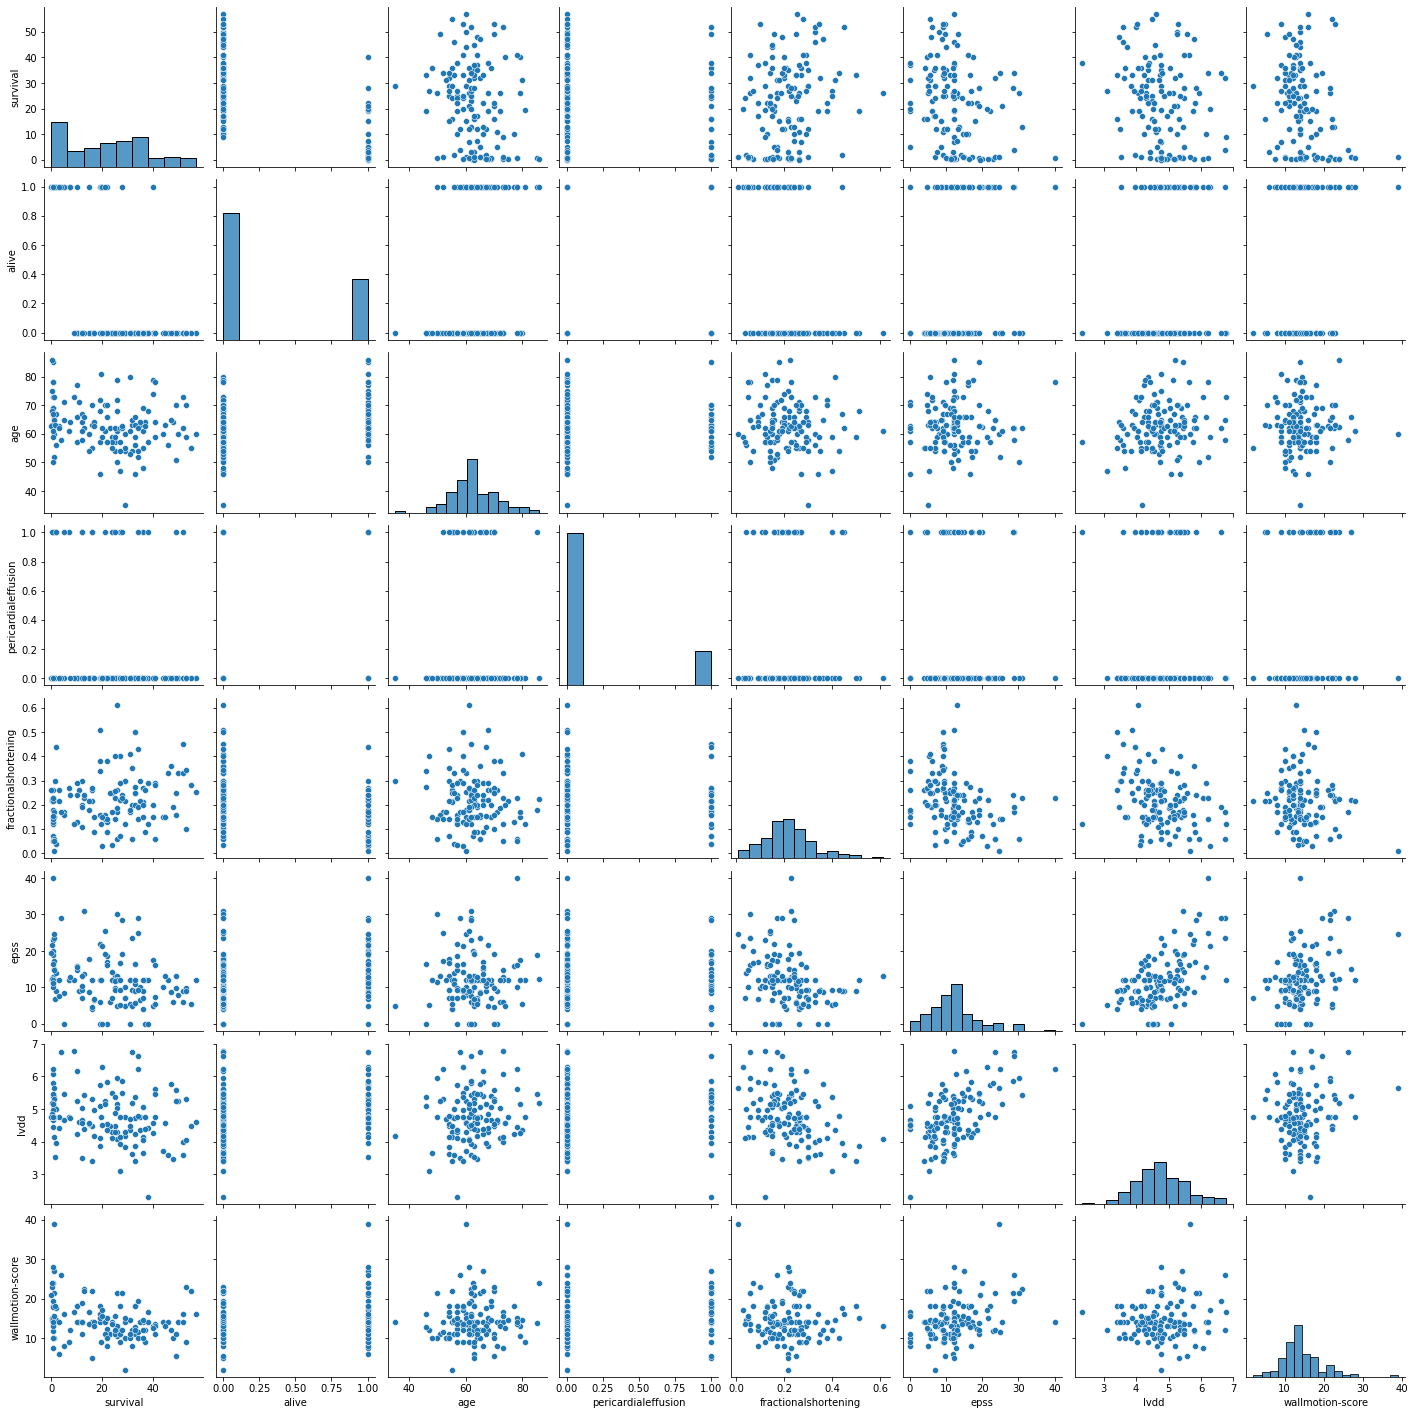

In [26]:
# scatter plot
sns.pairplot(df)

In [27]:
df.describe()

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,22.182923,0.323077,62.827674,0.184615,0.216863,12.186037,4.768874,14.428649
std,15.858267,0.469461,8.210192,0.389486,0.104972,6.984662,0.778480,4.978320
min,0.030000,0.000000,35.000000,0.000000,0.010000,0.000000,2.320000,2.000000
25%,7.875000,0.000000,57.250000,0.000000,0.150000,7.525000,4.295000,11.125000
50%,23.500000,0.000000,62.264500,0.000000,0.216734,12.000000,4.750000,14.000000
75%,33.000000,1.000000,67.000000,0.000000,0.267500,14.950000,5.257500,16.375000
max,57.000000,1.000000,86.000000,1.000000,0.610000,40.000000,6.780000,39.000000


For alive = 1 patients, because they are alive during data collection period and we do not know their survival months after the data collection, they are regarded as censored data. Hence, the following analysis needs to consider the censored data by making dead variable below.


In [28]:
df.loc[df.alive == 1, 'dead'] = 0
df.loc[df.alive == 0, 'dead'] = 1
df.groupby('dead').count()

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score
dead,,,,,,,,
0.0,42,42,42,42,42,42,42,42
1.0,88,88,88,88,88,88,88,88


In [29]:
88+42

130

We have 88 non-censored data and 42 censored data.



# Kaplan Meier 

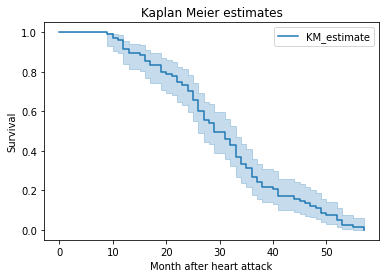

In [30]:
kmf = KaplanMeierFitter()
T = df['survival']
E = df['dead']
kmf.fit(T, event_observed = E)
kmf.plot()
plt.title("Kaplan Meier estimates")
plt.xlabel("Month after heart attack")
plt.ylabel("Survival")
plt.show()

I saw a slightly negative relationship of age and wallmotion-score to survival, so I used median to make two groups within each variable to see difference in survival time.

In [31]:
print(statistics.median(df['age']))
print(statistics.median(df['wallmotion-score']))

62.2645
14.0


Text(0, 0.5, 'Survival')

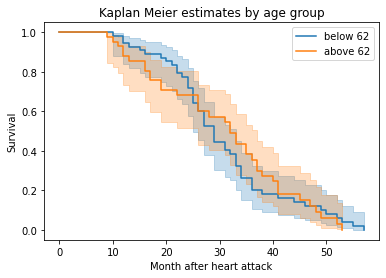

In [32]:
age_group = df['age'] < statistics.median(df['age'])
ax = plt.subplot(111)
kmf.fit(T[age_group], event_observed = E[age_group], label = 'below 62')
kmf.plot(ax = ax)
kmf.fit(T[~age_group], event_observed = E[~age_group], label = 'above 62')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by age group")
plt.xlabel("Month after heart attack")
plt.ylabel("Survival")

Text(0, 0.5, 'Survival')

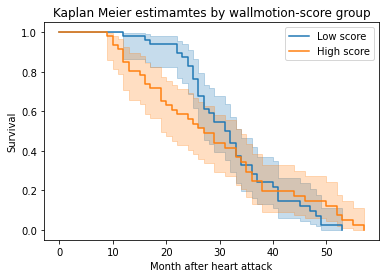

In [33]:
score_group = df['wallmotion-score'] < statistics.median(df['wallmotion-score'])
ax = plt.subplot(111)
kmf.fit(T[score_group], event_observed = E[score_group], label = 'Low score')
kmf.plot(ax = ax)
kmf.fit(T[~score_group], event_observed = E[~score_group], label = 'High score')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimamtes by wallmotion-score group")
plt.xlabel("Month after heart attack")
plt.ylabel("Survival")

The difference by age groups seems to be weak. However, there seems to differ by wallmotion-score group for the first 24 months (2 years) after heart attack. So I applied the following analysis based on wallmotion-score group.

# Log-rank test

In [34]:
month_cut = 24
df.loc[(df.dead == 1) & (df.survival <= month_cut), 'censored'] = 1
df.loc[(df.dead == 1) & (df.survival > month_cut), 'censored'] = 0
df.loc[df.dead == 0, 'censored'] = 0
E_v2 = df['censored']

T_low = T[score_group]
T_high = T[~score_group]
E_low = E_v2[score_group]
E_high = E_v2[~score_group]

results = logrank_test(T_low, T_high, event_observed_A = E_low, event_observed_B = E_high)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.98 <0.005      9.31

"test_statistic" here is a chi-square statistic. It shows chi-square statistic 9.98, and p-value is less than 5%. Thus, I confirm that there is a significant difference in suvival time by wallmotion score group for the first 2 year after heart attack.

# Cox proportional hazards model

In [35]:
cph = CoxPHFitter()
df_score_group = pd.DataFrame(score_group)
df_model = df[['survival', 'censored', 'age']]
df_model = pd.concat([df_model, df_score_group], axis = 1)
cph.fit(df_model, 'survival', 'censored')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 130 total observations, 102 right-censored observations>
             duration col = 'survival'
                event col = 'censored'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 28
   partial log-likelihood = -117.36
         time fit was run = 2022-05-03 11:32:28 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
age                0.02       1.02       0.02            -0.03             0.07                 0.97                 1.07
wallmotion-score  -1.27       0.28       0.42            -2.09            -0.45                 0.12                 0.64

                   cmp to     z      p   -log2(p)
covariate                                        
age                  0.00  0.88   0.38       1.39
wallmotion-score     0.00 -3.02 <0.005       8.63
---
Concordance = 0.70
Partial AIC = 238.71
log-likelihood ratio test = 10.68 on 2 df
-log2(p) of ll-ratio test = 7.71

In [36]:
# p-value of Log-likelihood ratio test
round(stats.chi2.sf(10.68, 2),4)

0.0048

Whether this model is significant or not depends on the result of Log-likelihood ratio test at the bottom of the summary. This statistic follows Chi-square distribution with 2 degree of freedom, and p-value is 0.0048. It says this cox model is significant so that statistical inference is based on this model. Wallmotion-score group is a risk factor for survival time, but age is not by checking p-values. Negative sign of wallmotion-score variable indicates that the patients with low wallmotion score reduce the risk of death. Hazard ration of wallmotion-score is 0.28, which means it reduce in hazard since it is less than 1 and it reduces the hazard by 72% (1 - 0.28). Thus, I conclude that for the first two years after each patient experiences heart attack, the people with high wallmotion score would have a higher risk of death so that we can pay attention to this group of patients